In [46]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import scipy.io as sio
import os
import numpy as np
import pandas as pd
import matplotlib as plt
import fastai
from fastai.conv_learner import *
from fastai.column_data import *
from torch.utils.data import *
import visdom as vis
import scipy.stats
import pickle

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
torch.cuda.get_device_name(0)

'GeForce GTX 1060 3GB'

### Utils

In [4]:
def pred_accuracy(m, x_val, y_val, ndata):
    x_val, indx = torch.max(m(x_val).cuda(),1)
    return (ndata - torch.nonzero((indx - y_val)).size(0))/ndata

## Data preprocessing and loading

In [5]:
PATH = 'L:/vibnet-hankooktire/CWRUdata/baseline/'

baselinedata = sio.loadmat(f'{PATH}'+'97', mdict=None, appendmat=True)

print(baselinedata)

def readFromFolder(PATH):
    
    list_of_data = []
    for file in os.listdir(PATH):
        x = sio.loadmat(f'{PATH}'+ file, appendmat=True)
        list_of_data.append(x)
    return list_of_data

## reading from folders
PATH = 'L:/vibnet-hankooktire/CWRUdata/baseline/'
baselined = readFromFolder(PATH)
PATH = 'L:/vibnet-hankooktire/CWRUdata/ball/' 
balld = readFromFolder(PATH)
PATH = 'L:/vibnet-hankooktire/CWRUdata/inner_race/'
iraced = readFromFolder(PATH)
PATH = 'L:/vibnet-hankooktire/CWRUdata/outer_race/'
oraced = readFromFolder(PATH)


baseDE = np.array(baselined[0]['X100_DE_time'])
baseDE = np.append(baseDE, baselined[1]['X097_DE_time'])
baseDE = np.append(baseDE, baselined[2]['X098_DE_time'])
baseDE = np.append(baseDE, baselined[3]['X099_DE_time'])

ballDE = np.array(balld[0]['X118_DE_time'])
ballDE = np.append(ballDE, balld[1]['X119_DE_time'])
ballDE = np.append(ballDE, balld[2]['X120_DE_time'])
ballDE = np.append(ballDE, balld[3]['X121_DE_time'])
ballDE = np.append(ballDE, balld[4]['X185_DE_time'])
ballDE = np.append(ballDE, balld[5]['X186_DE_time'])
ballDE = np.append(ballDE, balld[6]['X187_DE_time'])
ballDE = np.append(ballDE, balld[7]['X188_DE_time'])
ballDE = np.append(ballDE, balld[8]['X222_DE_time'])
ballDE = np.append(ballDE, balld[9]['X223_DE_time'])
ballDE = np.append(ballDE, balld[10]['X224_DE_time'])
ballDE = np.append(ballDE, balld[11]['X225_DE_time'])

oraceDE = np.array(oraced[0]['X130_DE_time'])
oraceDE = np.append(oraceDE, oraced[1]['X131_DE_time'])
oraceDE = np.append(oraceDE, oraced[2]['X132_DE_time'])
#oraceDE = np.append(oraceDE, oraced[3]['X133_DE_time'])
#oraceDE = np.append(oraceDE, oraced[4]['X144_DE_time'])
oraceDE = np.append(oraceDE, oraced[5]['X145_DE_time'])
#oraceDE = np.append(oraceDE, oraced[6]['X146_DE_time'])
#oraceDE = np.append(oraceDE, oraced[7]['X147_DE_time'])
oraceDE = np.append(oraceDE, oraced[8]['X156_DE_time'])
#oraceDE = np.append(oraceDE, oraced[9]['X158_DE_time'])
#oraceDE = np.append(oraceDE, oraced[10]['X159_DE_time'])
oraceDE = np.append(oraceDE, oraced[11]['X160_DE_time'])
#oraceDE = np.append(oraceDE, oraced[12]['X197_DE_time'])
#oraceDE = np.append(oraceDE, oraced[13]['X198_DE_time'])
oraceDE = np.append(oraceDE, oraced[14]['X199_DE_time'])
#oraceDE = np.append(oraceDE, oraced[15]['X200_DE_time'])
#oraceDE = np.append(oraceDE, oraced[16]['X234_DE_time'])
oraceDE = np.append(oraceDE, oraced[17]['X235_DE_time'])
#oraceDE = np.append(oraceDE, oraced[18]['X236_DE_time'])
oraceDE = np.append(oraceDE, oraced[19]['X237_DE_time'])
oraceDE = np.append(oraceDE, oraced[20]['X246_DE_time'])
#oraceDE = np.append(oraceDE, oraced[21]['X247_DE_time'])
#oraceDE = np.append(oraceDE, oraced[22]['X248_DE_time'])
oraceDE = np.append(oraceDE, oraced[23]['X249_DE_time'])
#oraceDE = np.append(oraceDE, oraced[24]['X258_DE_time'])
#oraceDE = np.append(oraceDE, oraced[25]['X259_DE_time'])
oraceDE = np.append(oraceDE, oraced[26]['X260_DE_time'])
#oraceDE = np.append(oraceDE, oraced[27]['X261_DE_time']

iraceDE = np.array(iraced[0]['X105_DE_time'])
iraceDE = np.append(iraceDE, iraced[1]['X106_DE_time'])
iraceDE = np.append(iraceDE, iraced[2]['X107_DE_time'])
iraceDE = np.append(iraceDE, iraced[3]['X108_DE_time'])
iraceDE = np.append(iraceDE, iraced[4]['X169_DE_time'])
iraceDE = np.append(iraceDE, iraced[5]['X170_DE_time'])
iraceDE = np.append(iraceDE, iraced[6]['X171_DE_time'])
iraceDE = np.append(iraceDE, iraced[7]['X172_DE_time'])
iraceDE = np.append(iraceDE, iraced[8]['X209_DE_time'])
iraceDE = np.append(iraceDE, iraced[9]['X210_DE_time'])
iraceDE = np.append(iraceDE, iraced[10]['X211_DE_time'])
iraceDE = np.append(iraceDE, iraced[11]['X212_DE_time'])


# Preparing pd.DataFrame for data labelled 0 (no fault)

n_samples = int(np.floor((len(baseDE))/(0.25*8192)))
n_samples

base_train = np.empty((829,2048), dtype = float)

for i in range(n_samples-1):
    base_train[i] = baseDE[i*2048:(i+1)*2048]

y = np.zeros((1,829),dtype=int)

basedf = pd.DataFrame(data=base_train)

basedf[2048] = y.squeeze(0)

# Preparing pd.DataFrame for data labelled 1 (ball fault)

n_samples = int(np.floor((len(ballDE))/(0.25*8192)))
n_samples

ball_train = np.empty((714,2048), dtype = float)

for i in range(n_samples-1):
    ball_train[i] = ballDE[i*2048:(i+1)*2048]
    
y = np.ones((1,714),dtype=int)

balldf = pd.DataFrame(data=ball_train)
balldf[2048] = y.squeeze(0)

# Preparing pd.DataFrame for data labelled 2 (inner race fault)

n_samples = int(np.floor((len(iraceDE))/(0.25*8192)))
#n_samples = 714

irace_train = np.empty((714,2048), dtype = float)

for i in range(n_samples-1):
    irace_train[i] = iraceDE[i*2048:(i+1)*2048]
    
y = np.full((1,714), 2, dtype=int)

iracedf = pd.DataFrame(data=irace_train)
iracedf[2048] = y.squeeze(0)

# Preparing pd.DataFrame for data labelled 3 (outer race fault)

n_samples = int(np.floor((len(oraceDE))/(0.25*8192)))
#n_samples = 714

orace_train = np.empty((714,2048), dtype = float)

for i in range(n_samples-1):
    orace_train[i] = oraceDE[i*2048:(i+1)*2048]
    
y = np.full((1,714), 3, dtype=int)

oracedf = pd.DataFrame(data=orace_train)
oracedf[2048] = y.squeeze(0)

# Random uniform sampling, 70% train 30% valid/test

baseline_input = basedf.sample(frac=0.7, random_state=1)
ball_input = balldf.sample(frac=0.7, random_state=1)
irace_input = iracedf.sample(frac=0.7, random_state=1)
orace_input = oracedf.sample(frac=0.7, random_state=1)

baseline_valid = basedf.drop(baseline_input.index)
ball_valid = balldf.drop(ball_input.index)
irace_valid = iracedf.drop(irace_input.index)
orace_valid = oracedf.drop(orace_input.index)

concatdf = [baseline_input, ball_input, irace_input, orace_input]
concatdf_valid = [baseline_valid, ball_valid, irace_valid, orace_valid]
x = pd.concat(concatdf)
x_val = pd.concat(concatdf_valid)

y = x[2048]
y_val = x_val[2048]

x.drop(x.columns[len(x.columns)-1], axis=1, inplace=True)
x_val.drop(x_val.columns[len(x_val.columns)-1], axis=1, inplace=True)

# Data massaging for PyTorch DataLoaders

#using float so we don't run into float vs double inconsistencies during training
x = torch.from_numpy(np.array(x)).float().cuda()
x_val = torch.from_numpy(np.array(x_val)).float().cuda()
y = torch.from_numpy(np.array(y)).long().cuda()
y_val = torch.from_numpy(np.array(y_val)).long().cuda()

train = TensorDataset(x, y)
val = TensorDataset(x_val, y_val)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Mon Jan 31 15:28:20 2000', '__version__': '1.0', '__globals__': [], 'X097_DE_time': array([[ 0.0532 ],
       [ 0.08866],
       [ 0.09972],
       ...,
       [-0.03463],
       [ 0.01669],
       [ 0.04694]]), 'X097_FE_time': array([[0.14567],
       [0.0978 ],
       [0.05486],
       ...,
       [0.14053],
       [0.09554],
       [0.09019]]), 'X097RPM': array([[1796]], dtype=uint16)}


## Model

In [6]:
class CNN(nn.Module):
    def __init__(self, conv_layers, layers):
        super().__init__()
        self.conv_layers = nn.ModuleList([nn.Conv1d(conv_layers[i], conv_layers[i + 1], kernel_size = 3) 
                                     for i in range(len(conv_layers) - 1)])
        self.layers = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        
        self.pool = nn.MaxPool1d(2)
        self.conv_dropout = nn.Dropout(0.25)
        self.l_dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        x = x.view(x.size(0), 1, -1)
        
        for l in self.conv_layers:
            l_x = l(x)
            bn = nn.BatchNorm1d(x.size())
            x = F.relu(l_x)
            #x = self.pool(x)
            #x = self.conv_dropout(x)
        
        x = x.view(x.size(0), -1)
        for l in self.layers:
            l_x = l(x)
            bn = nn.BatchNorm1d(x.size())
            x = F.relu(l_x)
            #x = self.l_dropout(x)
        return F.log_softmax(l_x, dim=-1)

In [43]:
m = CNN([1, 3, 10, 3], [6126, 512, 4]).cuda()

## PAC-Adaptive sampling

In [22]:
def updateSampleWeights(w, idx, tau, alpha, f):
    #decaying towards uniform distribution
    w = (w - 1/np.size(w))*math.exp(-tau) + 1/np.size(w)
    
    #calculating actual update
    #check whether we are in epoch 1 or higher number of training epochs. wrap-around
    if idx >= np.size(w):
        w[idx-np.size(w)] = w[idx-np.size(w)] * math.exp(alpha * f)
    else:
        w[idx] = w[idx] * math.exp(alpha * f)
    #normalizing
    w = w/np.sum(w)
    return w     

Decay rule: $$ q_{i} = (q_{i} - \frac{1}{N})*e^{-\tau} + \frac{1}{N} $$

## Training loop: Unif-samp SGD

In [45]:
trainloader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=True, num_workers=0, sampler=None)
opt = torch.optim.Adam(m.parameters(), weight_decay= 0, lr=0.001)
data_collunif = {'loss':np.zeros(40),'kl':np.zeros(40),'acc':np.zeros(40)}
#scheduler = torch.optim.lr_scheduler.StepLR(opt,5,0.95)
experiment_collection1 = {}

for experiment in range(10):
    for epoch in range(2): 

        running_acc = 0.0
        #running_kl = 0.0
        running_loss = 0.0
        #loop to update the distribution over the examples
        for i, data in enumerate(trainloader, 0):        

            inputs, labels = data
            #inputs, labels = inputs.to(device), labels.to(device)

            opt.zero_grad()

            outputs = m(inputs)
            loss = F.nll_loss(outputs, labels) 
            loss.backward()
            opt.step()
            #scheduler.step()

            #_, predicted = outputs.max(1)

            running_loss += loss.item()
            #running_kl += scipy.stats.entropy(w,w_unif)
            running_acc += pred_accuracy(m, x_val, y_val, x_val.size(0))

            if (i % 100 == 0) and (i != 0):   
                print('[%d, %5d] loss: %.3f acc: %.3f kl div: %.3f' %
                      (epoch, i , running_loss / 100, running_acc / 100, running_kl / 100))

                j = int(i/100)
                data_collunif['loss'][j+2048*epoch] = running_loss/100
                #data_collunif['kl'][j+2048*epoch] = running_kl/100
                data_collunif['acc'][j+2048*epoch] = running_acc/100
                running_acc = 0.0
                #running_kl = 0.0
                running_loss = 0.0
    experiment_collection1[experiment] = data_collunif
    pickle_to_file(experiment_collection1, 'experimentsUNIF.pickle')

[0,   100] loss: 1.489 acc: 0.248 kl div: 0.000
[0,   200] loss: 1.300 acc: 0.317 kl div: 0.000
[0,   300] loss: 1.154 acc: 0.482 kl div: 0.000
[0,   400] loss: 1.087 acc: 0.592 kl div: 0.000
[0,   500] loss: 0.915 acc: 0.547 kl div: 0.000
[0,   600] loss: 0.904 acc: 0.554 kl div: 0.000
[0,   700] loss: 0.792 acc: 0.601 kl div: 0.000
[0,   800] loss: 0.850 acc: 0.716 kl div: 0.000
[0,   900] loss: 0.881 acc: 0.609 kl div: 0.000
[0,  1000] loss: 0.653 acc: 0.789 kl div: 0.000
[0,  1100] loss: 0.535 acc: 0.862 kl div: 0.000
[0,  1200] loss: 0.472 acc: 0.892 kl div: 0.000
[0,  1300] loss: 0.439 acc: 0.909 kl div: 0.000
[0,  1400] loss: 0.353 acc: 0.920 kl div: 0.000
[0,  1500] loss: 0.306 acc: 0.915 kl div: 0.000
[0,  1600] loss: 0.212 acc: 0.929 kl div: 0.000
[0,  1700] loss: 0.260 acc: 0.921 kl div: 0.000
[0,  1800] loss: 0.359 acc: 0.903 kl div: 0.000
[0,  1900] loss: 0.254 acc: 0.925 kl div: 0.000
[0,  2000] loss: 0.340 acc: 0.921 kl div: 0.000
[1,   100] loss: 0.274 acc: 0.929 kl div

IndexError: index 40 is out of bounds for axis 0 with size 40

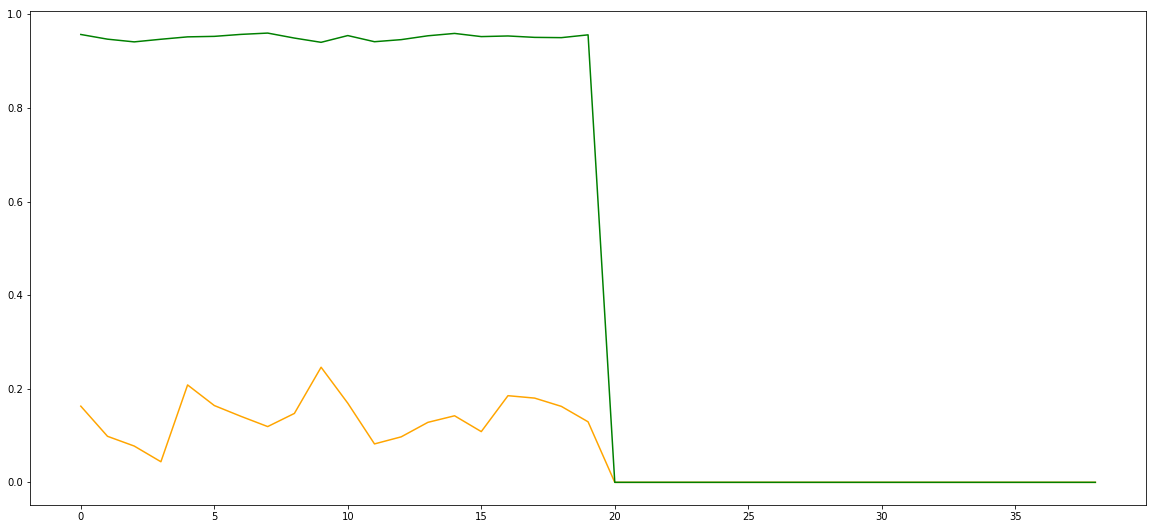

In [282]:
fig = plt.figure(figsize=(20,20), facecolor = 'white')
fig.add_subplot(2,1,1)
plt.plot(data_collunif['loss'][1:40], color='orange')
plt.plot(data_collunif['acc'][1:40], color='green')

## Training loop: AdaSamp SGD (0-1 utility)

### How many training examples?

In [150]:
x.shape

torch.Size([2080, 2048])

2080 time-series of 2048 points

In [261]:
opt = torch.optim.Adam(m.parameters(), weight_decay= 0, lr=0.001)
#scheduler = torch.optim.lr_scheduler.StepLR(opt,5,0.5)

In [262]:
w = np.full((2048), 1/2048)
w_unif = np.full((2048), 1/2048)
samp = torch.utils.data.WeightedRandomSampler(torch.Tensor(w).cuda(), 4000)
trainloader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=False, num_workers=0, sampler=samp)

In [263]:
tau = 0.25
alpha = 0.25
data_coll = {'loss':np.zeros(40),'kl':np.zeros(40),'acc':np.zeros(40)}
experiment_collection1 = {}

for experiment in range(10):
    for epoch in range(1): 

        running_loss = 0.0
        running_kl = 0.0
        running_acc = 0.0
        for i, data in enumerate(trainloader, 0):

            inputs, labels = data
            #inputs, labels = inputs.to(device), labels.to(device)
            #scheduler.step()
            opt.zero_grad()

            outputs = m(inputs)
            loss = F.nll_loss(outputs, labels) 
            loss.backward()
            opt.step()

            _ , predicted = torch.max(outputs,1)

            #0-1 utility pred
            if predicted == labels:
                f = 0
            else: 
                f = 1

            running_loss += loss.item()
            running_kl += scipy.stats.entropy(w,w_unif)
            running_acc += pred_accuracy(m, x_val, y_val, x_val.size(0))

            if (i % 100 == 0) and (i != 0):   
                print('[%d, %5d] loss: %.3f acc: %.3f kl div: %.3f' %
                      (epoch, i , running_loss / 100, running_acc / 100, running_kl / 100))

                j = int(i/100)
                data_coll['loss'][j] = running_loss/100
                data_coll['kl'][j] = running_kl/100
                data_coll['acc'][j] = running_acc/100
                running_acc = 0.0
                running_kl = 0.0
                running_loss = 0.0


            #PAC adaptive sampling
            w = updateSampleWeights(w, i, tau, alpha, f)
            #update dataloader sampler
            samp.weights = torch.Tensor(w).cuda()
    experiment_collection2[experiment] = data_coll
    pickle_to_file(experiment_collection2, 'AdaSGD.pickle')

[0,   100] loss: 1.538 acc: 0.264 kl div: 1.538
[0,   200] loss: 1.348 acc: 0.337 kl div: 1.348
[0,   300] loss: 1.134 acc: 0.530 kl div: 1.134
[0,   400] loss: 0.916 acc: 0.564 kl div: 0.916
[0,   500] loss: 0.917 acc: 0.608 kl div: 0.917
[0,   600] loss: 0.852 acc: 0.651 kl div: 0.852
[0,   700] loss: 0.726 acc: 0.691 kl div: 0.726
[0,   800] loss: 0.669 acc: 0.680 kl div: 0.669
[0,   900] loss: 0.790 acc: 0.594 kl div: 0.790
[0,  1000] loss: 0.629 acc: 0.721 kl div: 0.629
[0,  1100] loss: 0.634 acc: 0.725 kl div: 0.634
[0,  1200] loss: 0.570 acc: 0.792 kl div: 0.570
[0,  1300] loss: 0.513 acc: 0.770 kl div: 0.513
[0,  1400] loss: 0.456 acc: 0.812 kl div: 0.456
[0,  1500] loss: 0.371 acc: 0.817 kl div: 0.371
[0,  1600] loss: 0.404 acc: 0.850 kl div: 0.404
[0,  1700] loss: 0.299 acc: 0.851 kl div: 0.299
[0,  1800] loss: 0.321 acc: 0.855 kl div: 0.321
[0,  1900] loss: 0.359 acc: 0.844 kl div: 0.359
[0,  2000] loss: 0.290 acc: 0.888 kl div: 0.290
[0,  2100] loss: 0.297 acc: 0.869 kl div

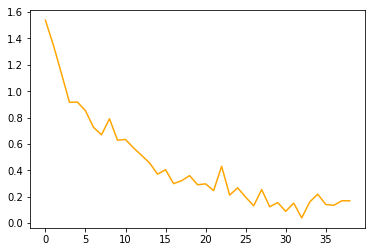

In [273]:
plt.plot(data_coll['loss'][1:40], color='orange')

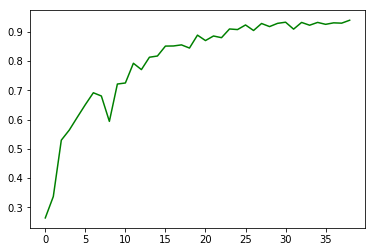

In [274]:
plt.plot(data_coll['acc'][1:40], color='green')

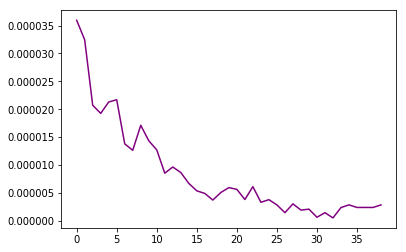

In [276]:
plt.plot(data_coll['kl'][1:40], color='purple')

In [256]:
m = CNN([1, 3, 10, 3], [6126, 512, 4]).cuda()

## Training loop: AdaSamp SGD (L1 utility)

In [306]:
cuda.empty_cache()

In [39]:
opt = torch.optim.Adam(m.parameters(), weight_decay= 0, lr=0.001)
#scheduler = torch.optim.lr_scheduler.StepLR(opt,5,0.5)
w = np.full((2048), 1/2048)
w_unif = np.full((2048), 1/2048)
samp = torch.utils.data.WeightedRandomSampler(torch.Tensor(w).cuda(), 4000)
trainloader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=False, num_workers=0, sampler=samp)

In [40]:
tau = 0.25
alpha = 0.25
data_collL1 = {'loss':np.zeros(40),'kl':np.zeros(40),'acc':np.zeros(40)}

for epoch in range(1): 
       
    running_loss = 0.0
    running_kl = 0.0
    running_acc = 0.0
    for i, data in enumerate(trainloader, 0):
                
        inputs, labels = data
        #inputs, labels = inputs.to(device), labels.to(device)
        #scheduler.step()
        opt.zero_grad()

        outputs = m(inputs)
        loss = F.nll_loss(outputs, labels) 
        loss.backward()
        opt.step()
        
        _ , predicted = torch.max(outputs,1)
        
        #L1 utility 
        if predicted == labels:
            f = 0
        else: 
            f = labels.float() - torch.exp(outputs[:,labels])
        
        running_loss += loss.item()
        running_kl += scipy.stats.entropy(w,w_unif)
        running_acc += pred_accuracy(m, x_val, y_val, x_val.size(0))

        if (i % 100 == 0) and (i != 0):   
            print('[%d, %5d] loss: %.3f acc: %.3f kl div: %.3f' %
                  (epoch, i , running_loss / 100, running_acc / 100, running_kl / 100))
            
            j = int(i/100)
            data_collL1['loss'][j] = running_loss/100
            data_collL1['kl'][j] = running_kl/100
            data_collL1['acc'][j] = running_acc/100
            running_acc = 0.0
            running_kl = 0.0
            running_loss = 0.0
        
        
        #PAC adaptive sampling
        w = updateSampleWeights(w, i, tau, alpha, f)
        #update dataloader sampler
        samp.weights = torch.Tensor(w).cuda()   

[0,   100] loss: 1.142 acc: 0.523 kl div: 0.000
[0,   200] loss: 0.931 acc: 0.559 kl div: 0.000
[0,   300] loss: 0.868 acc: 0.575 kl div: 0.000
[0,   400] loss: 0.799 acc: 0.652 kl div: 0.000
[0,   500] loss: 0.748 acc: 0.652 kl div: 0.000
[0,   600] loss: 0.658 acc: 0.677 kl div: 0.000
[0,   700] loss: 0.608 acc: 0.683 kl div: 0.000
[0,   800] loss: 0.614 acc: 0.730 kl div: 0.000
[0,   900] loss: 0.542 acc: 0.745 kl div: 0.000
[0,  1000] loss: 0.412 acc: 0.777 kl div: 0.000
[0,  1100] loss: 0.504 acc: 0.750 kl div: 0.000
[0,  1200] loss: 0.578 acc: 0.770 kl div: 0.000
[0,  1300] loss: 0.434 acc: 0.840 kl div: 0.000
[0,  1400] loss: 0.289 acc: 0.848 kl div: 0.000
[0,  1500] loss: 0.377 acc: 0.846 kl div: 0.000
[0,  1600] loss: 0.263 acc: 0.859 kl div: 0.000
[0,  1700] loss: 0.313 acc: 0.881 kl div: 0.000
[0,  1800] loss: 0.376 acc: 0.884 kl div: 0.000
[0,  1900] loss: 0.242 acc: 0.892 kl div: 0.000
[0,  2000] loss: 0.262 acc: 0.898 kl div: 0.000
[0,  2100] loss: 0.274 acc: 0.898 kl div

In [304]:
m = CNN([1, 3, 10, 3], [6126, 512, 4]).cuda()

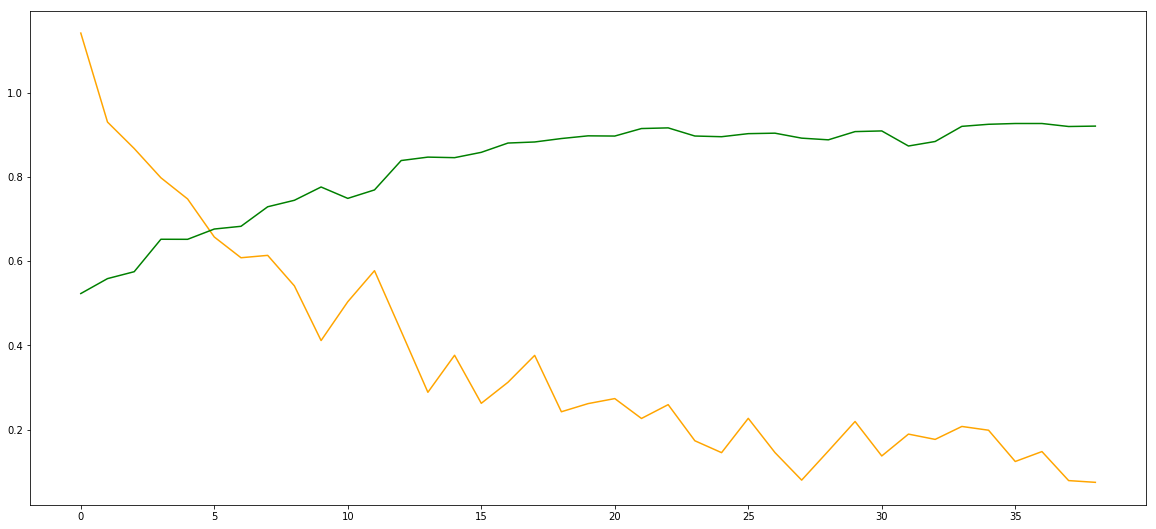

In [42]:
fig = plt.figure(figsize=(20,20), facecolor = 'white')
fig.add_subplot(2,1,1)
plt.plot(data_collL1['loss'][1:40], color='orange')
plt.plot(data_collL1['acc'][1:40], color='green')

## Plot comparisons

In [ ]:
fig = plt.figure(figsize=(20,20), facecolor = 'white')
fig.add_subplot(3,1,1)
plt.plot(data_coll['loss'][1:40], color='orange')
plt.plot(data_colluniform['loss'][1:40], color='green')

In [72]:
def pickle_to_file(data, filename, PATH = 'L:/vibnet-hankooktire/'):
    with open(filename, 'wb') as handle:
        pickle.dump(data, handle)
def file_to_pickle(filename, PATH = 'L:/vibnet-hankooktire/'):
    with open(filename, 'rb') as handle:
        return pickle.load(handle)               

In [62]:
pickle_to_file(data_collunif, 'unifSGD.pickle')
#pickle_to_file(data_coll, 'AdaSGD01.pickle')
pickle_to_file(data_collL1, 'AdaSGDL1.pickle')

In [70]:
with open('unifSGD.pickle', 'rb') as handle:
    x = pickle.load(handle)

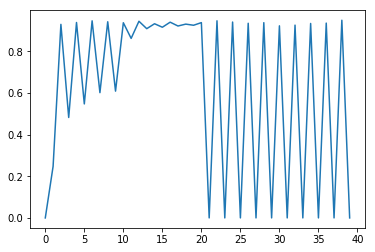

In [69]:
plt.plot(x['acc'])

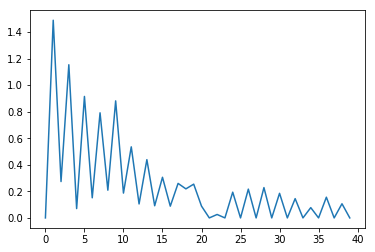

In [71]:
plt.plot(data_collunif['loss'])

In [73]:
kappa = {'apple':[1,2],'pippo':[4,5]}

In [75]:
kappa['apple']

[1, 2]

In [84]:
experiment_collection[0] = kappa

In [83]:
experiment_collection = {}

In [85]:
experiment_collection

{0: {'apple': [1, 2], 'pippo': [4, 5]}}